<a href="https://colab.research.google.com/github/ddeniel1/MDS_COVID_ANALYSIS/blob/main/MDS_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 - Carregando os dados**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importando pandas**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial import distance_matrix

## **Importando os dados**

In [ ]:
data = pd.read_csv('/content/drive/Shareddrives/MQAA/dados/dados anallise fatorial/owid-covid-data.csv')

In [ ]:
data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148557,ZWE,Africa,Zimbabwe,2021-12-15,177690.0,5678.0,3866.000,4745.0,5.0,3.571,11773.654,376.222,256.159,314.401,0.331,0.237,1.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12690.0,1609889.0,106.670,0.841,12544.0,0.831,0.3082,3.2,tests performed,7013400.0,4000022.0,3013378.0,NaN,33000.0,25508.0,46.47,26.50,19.97,NaN,1690.0,13044.0,0.086,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
148558,ZWE,Africa,Zimbabwe,2021-12-16,182057.0,4367.0,3748.571,4759.0,14.0,5.143,12063.009,289.355,248.379,315.329,0.928,0.341,1.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12390.0,1622279.0,107.491,0.821,12471.0,0.826,0.3006,3.3,tests performed,7058474.0,4023289.0,3035185.0,N

In [ ]:
data = data.bfill()

# 2 - MDS
https://towardsdatascience.com/visualize-multidimensional-datasets-with-mds-64d7b4c16eaa

http://www.analytictech.com/networks/mds.htm


## Tratamento de dados

In [ ]:
def idh_meter(x):
  if (x<= 0.499):
    return 0 #'sub-desenvolvido'
  if (x> 0.5 and x<0.799):
    return 1 #'em desenvolvimento'
  if (x> 0.8):
    return 2 #'desenvolvido'

In [ ]:
# Definindo intervalo de tempo para agregação dos ,
# Quanto mais datas, mais pesado o mds fica pra analisar a resposta de cada objeto --> peguei 3 pra caso falte algum dado em um dia
dates = data['date'].isin(['2021-12-01','2021-11-01','2021-10-01'])

In [ ]:
data = data.assign(idh_label=data[dates].copy()['human_development_index'].apply(idh_meter)).bfill().dropna()

In [ ]:
analise = np.empty(5, dtype=object) 
# Análise 1
analise[0] = data[dates].copy()[['location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'reproduction_rate', 'icu_patients', 'hosp_patients', 'weekly_icu_admissions',
            'weekly_hosp_admissions', 'new_tests', 'total_tests','positive_rate', 'tests_units', 'total_vaccinations', 'people_fully_vaccinated', 'total_boosters',
             'new_vaccinations', 'stringency_index','population', 'population_density', 'median_age', 'aged_65_older',
             'aged_70_older', 'gdp_per_capita', 'extreme_poverty','cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
             'male_smokers','life_expectancy', 'human_development_index','excess_mortality_cumulative','excess_mortality','idh_label']].copy()

# Análise 2
analise[1] = data[dates].copy()[['total_cases','total_deaths','icu_patients', 'hosp_patients','total_tests','positive_rate','total_vaccinations', 'people_fully_vaccinated', 'total_boosters',
                          'stringency_index','median_age', 'aged_65_older','aged_70_older', 'gdp_per_capita', 'extreme_poverty','cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
                           'male_smokers','life_expectancy', 'human_development_index','excess_mortality_cumulative','excess_mortality','idh_label']].copy()

# Análise 3
analise[2] = data[dates].copy()[['total_cases','total_deaths','icu_patients', 'hosp_patients','total_tests','positive_rate','total_vaccinations', 'people_fully_vaccinated', 'total_boosters',
                         'stringency_index', 'gdp_per_capita', 'extreme_poverty','human_development_index','life_expectancy', 'idh_label','excess_mortality_cumulative','excess_mortality']].copy()

# Análise 4
analise[3] = data[dates].copy()[['total_cases','total_deaths','icu_patients', 'hosp_patients','total_tests','positive_rate','total_vaccinations', 'people_fully_vaccinated', 'total_boosters',
                           'stringency_index','life_expectancy','human_development_index','excess_mortality_cumulative','excess_mortality','idh_label']].copy()

# Análise 5
analise[4] = data[dates].copy()[['total_cases','total_deaths','icu_patients','total_vaccinations','idh_label', 'people_fully_vaccinated', 'total_boosters','human_development_index']].copy()

for i in range(len(analise)):
  analise[i].idh_label = analise[i].idh_label.astype(int)
data.idh_label = data.idh_label.astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
def scaler_data(dataAnalysis):
  scaler = MinMaxScaler()
  numeric_cols = dataAnalysis.select_dtypes(include=[np.number]).columns
  data_scaled = scaler.fit_transform(dataAnalysis[numeric_cols])
  return data_scaled

## Matriz de distâncias (dissimilaridade) do dataset principal
(Usada posteriormente na avaliação do modelo)

In [ ]:
def matrixDistanceCalc(data_scaled, data):
  distanceMatrix = pd.DataFrame(distance_matrix(data_scaled, data_scaled), index=data.index, columns=data.index)

  return distanceMatrix

## Análise de stress (Método Elbow)

In [ ]:
# Quanto mais variáveis mais estresse é gerado pra diminuir o número de dimensões.
def elbowPlot(data_scaled, distance_matrix, i):
  estresse = []

  D = range(1,10)
  for d in D:
      mds = MDS(d,random_state=0)
      mds.fit(data_scaled)

      points = mds.embedding_
      DE = euclidean_distances(points)
      stress = 0.5 * np.sum((DE - distance_matrix.values)**2)
      stress1 = np.sqrt(stress / (0.5 * np.sum(distance_matrix.values**2)))
      estresse.append(stress1)
     
  plt.figure(figsize=(16,8))
  plt.plot(D, estresse, 'bx-')
  plt.xlabel('d')
  plt.ylabel('Estresse')
  plt.title('Método Elbow')
  fig1 = plt.gcf()
  plt.show()
  fileName = '/content/drive/Shareddrives/MQAA/dados/mds/analise_'+str(i+1)+'/elbow'
  fig1.savefig(fileName)

## MDS - 2D

In [ ]:
def mds2d(data_scaled, data, k):
  mds = MDS(2,random_state=0)
  data_2d = mds.fit_transform(data_scaled)
  colors = ['red','green','blue']
  plt.rcParams['figure.figsize'] = [7, 7]
  plt.rc('font', size=14)

  target_names = ['subdesenvolvido','em desenvolvimento','desenvolvido']

  for i in np.unique(data.idh_label):
    subset = data_2d[data.idh_label == i]
    
    x = [row[0] for row in subset]
    y = [row[1] for row in subset]  

    plt.scatter(x,y,c=colors[i],label=target_names[i])

  plt.legend()
  
  fig1 = plt.gcf()
  plt.show()
  fileName = '/content/drive/Shareddrives/MQAA/dados/mds/analise_'+ str(k+1) +'/mds_2d'
  fig1.savefig(fileName)
  return mds

## Avaliação do modelo 2D

In [ ]:
# Desenvolvido está em um cluster totalmente oposto ao subdesenvolvido
# Usando as variáveis, notamos que há claramente uma similaridade de países no combate a propagação da covid com base em seu desenvolvimento
# 2D tem um nível de estresse mais alto do que o em 3D ("good"), porém está no nível "fair" ainda.

## MDS - 3D

In [ ]:
import matplotlib.animation

def mds3d(data_scaled, data, k):

  mds = MDS(3,random_state=0)
  data_3d = mds.fit_transform(data_scaled)

  colors = ['red','green','blue']

  fig = plt.figure(figsize = (10,10))
  ax = plt.axes(projection='3d')
  ax.grid()

  target_names = ['subdesenvolvido','em desenvolvimento','desenvolvido']

  for i in np.unique(data.idh_label):
    subset = data_3d[data.idh_label == i]
    
    x = [row[0] for row in subset]
    y = [row[1] for row in subset]
    z = [row[2] for row in subset]  

    ax.scatter(x,y,z, c=colors[i], s=50)

  ax.set_title('3D Scatter Plot')

  #ax.view_init(azim=0, elev=90)

  plt.legend()
  fig1 = plt.gcf()
  plt.show()
  fileName = '/content/drive/Shareddrives/MQAA/dados/mds/analise_'+ str(k+1) +'/mds_3d'
  fig1.savefig(fileName)
  return mds

## Avaliação do modelo 3D

In [ ]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances

def MDSAnalysis(mds, distance_matrix, model, i):

  # Coordinates of points in the plan (n_components=2)
  points = mds.embedding_

  lines = ['Analise '+str(i+1)+': \n\n'] * 11

  ## sklearn Stress
  lines[1] = 'sklearn stress : '
  lines[2] = str(mds.stress_) + '\n' # Não normalizado
  lines[3] = '\n'

  ## Manual calculus of sklearn stress
  DE = euclidean_distances(points)
  stress = 0.5 * np.sum((DE - distance_matrix.values)**2)
  lines[4] = 'Manual calculus of sklearn stress : '
  lines[5] = str(stress) + '\n'
  lines[6] = '\n'

  ## Kruskal's stress (or stress formula 1)
  stress1 = np.sqrt(stress / (0.5 * np.sum(distance_matrix.values**2)))
  lines[7] = 'Kruskal\'s Stress :'
  lines[8] = '[Poor > 0.2 > Fair > 0.1 > Good > 0.05 > Excellent > 0.025 > Perfect > 0.0] \n'
  lines[9] = str(stress1) + '\n'
  lines[10] = '\n'
  with open('/content/drive/Shareddrives/MQAA/dados/mds/mds_'+model+'_analysis.txt', 'a') as f:
    f.writelines(lines)
    f.write('\n')

##3 - Reprodução das análises salvando no drive

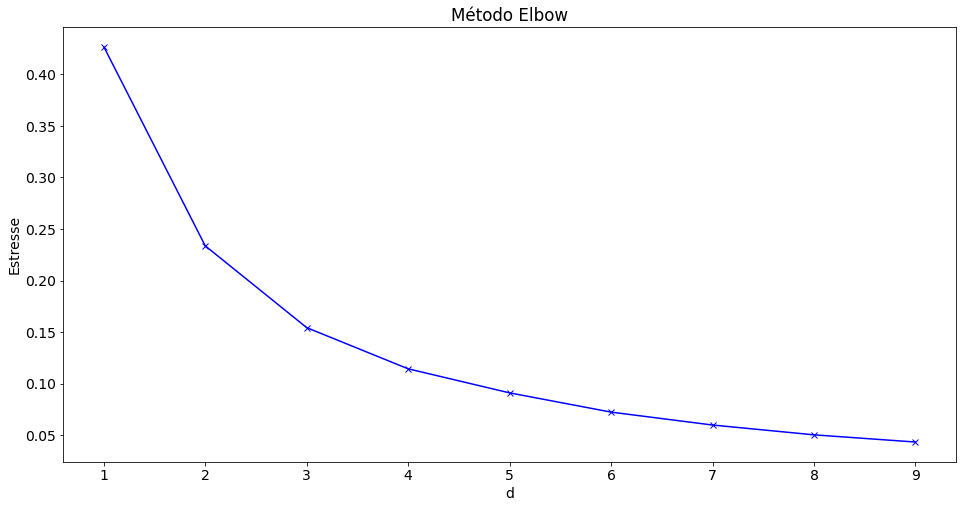

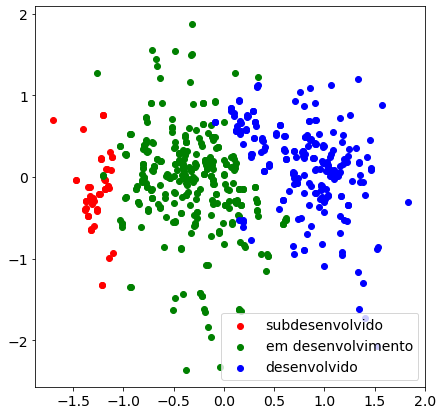

No handles with labels found to put in legend.


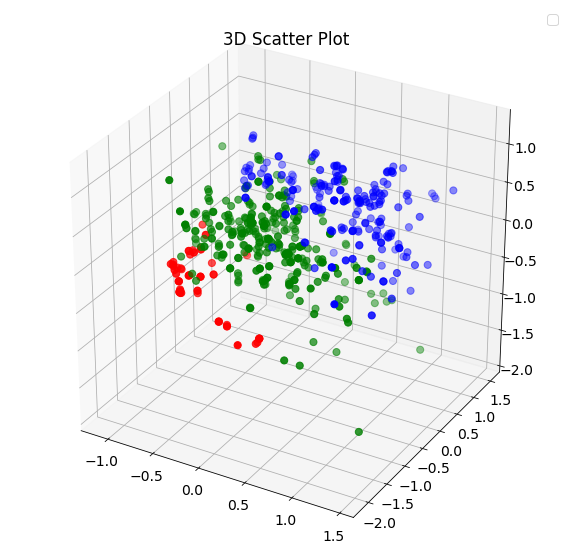

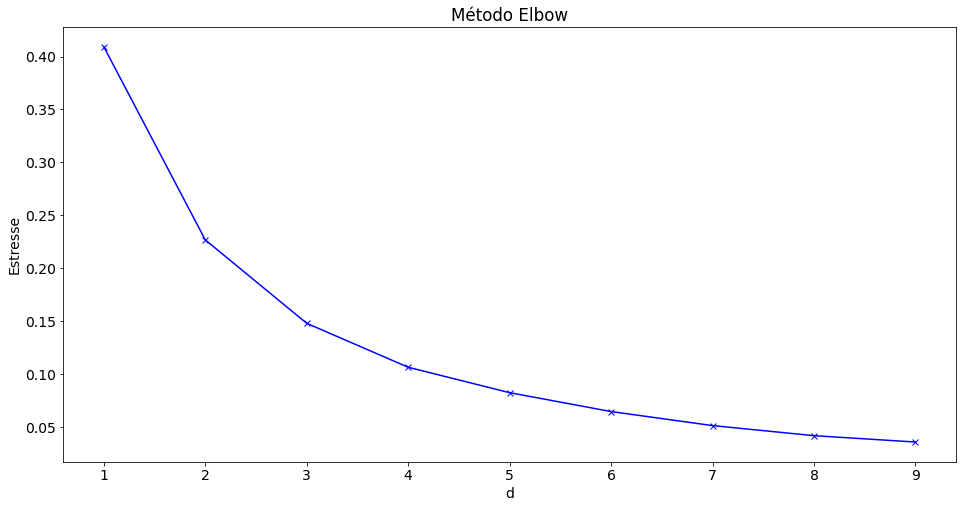

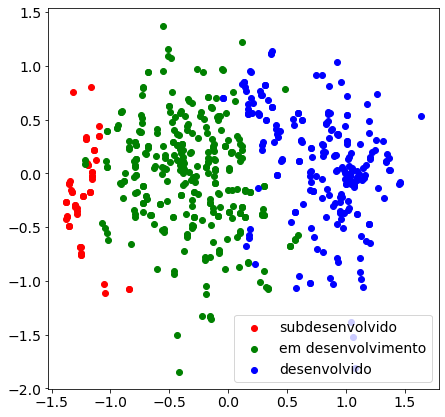

No handles with labels found to put in legend.


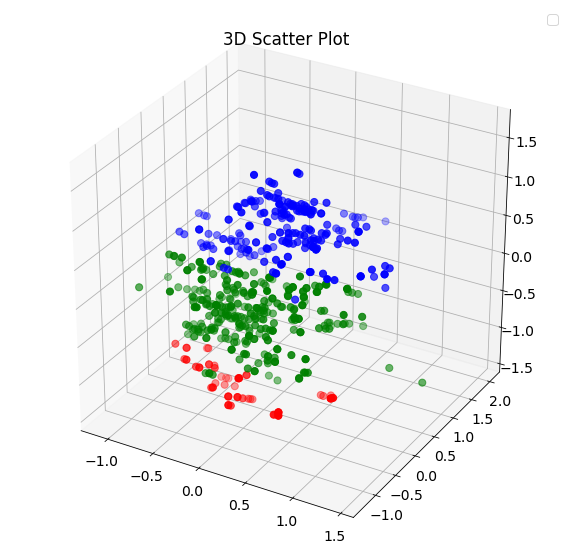

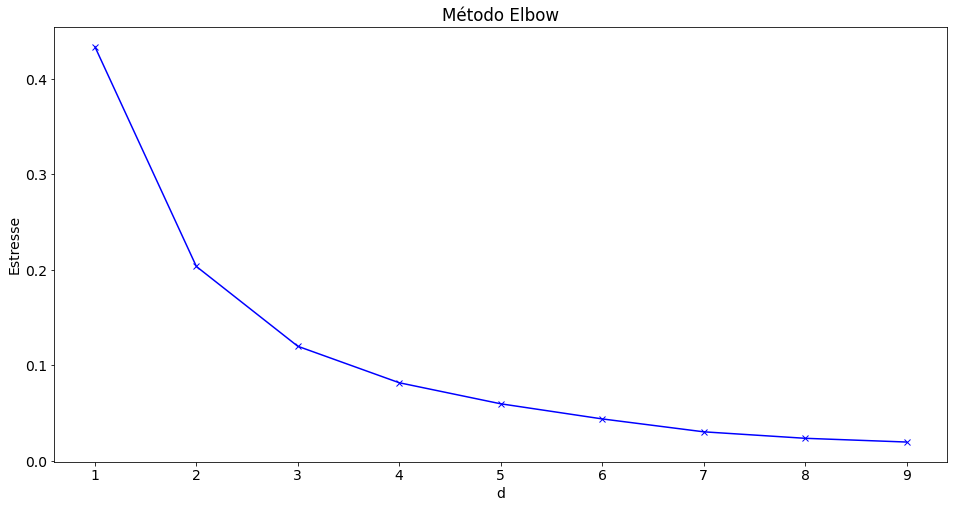

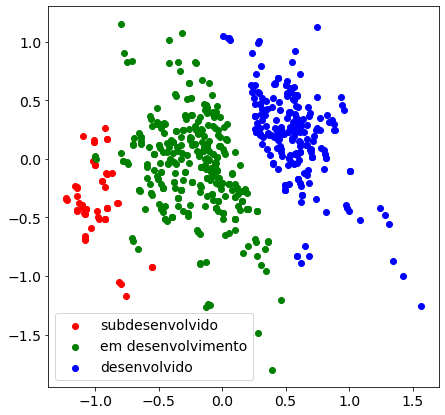

No handles with labels found to put in legend.


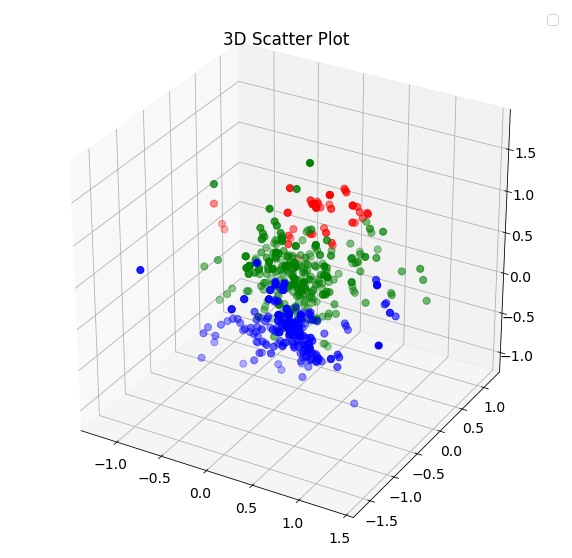

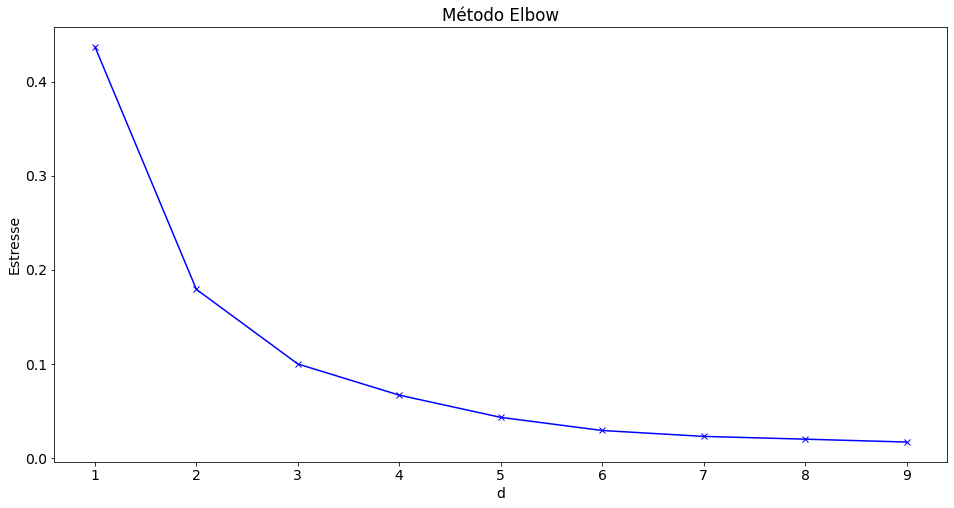

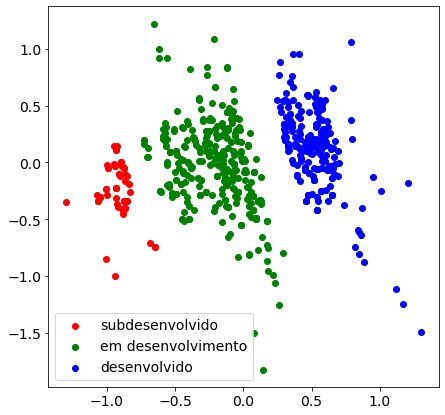

No handles with labels found to put in legend.


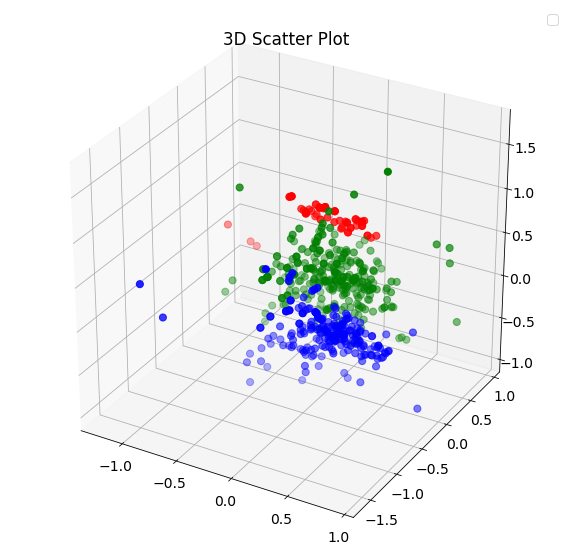

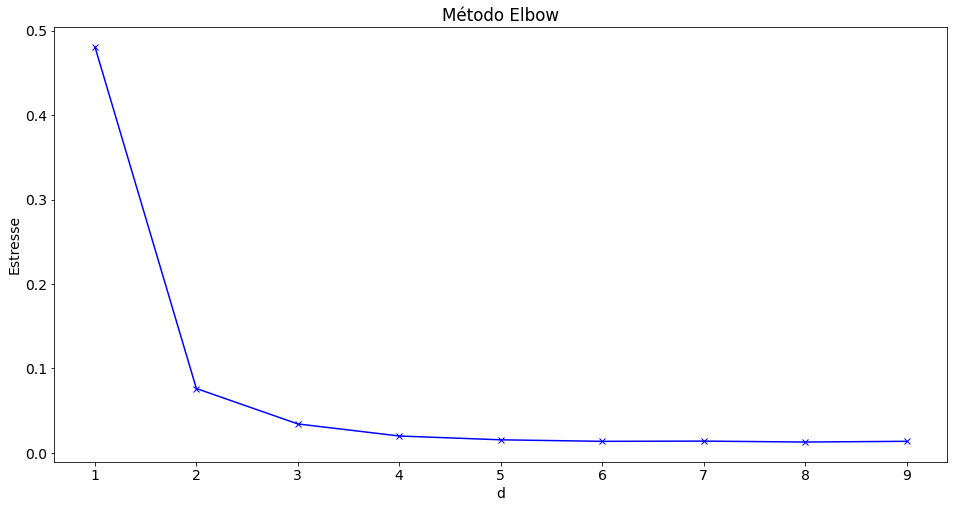

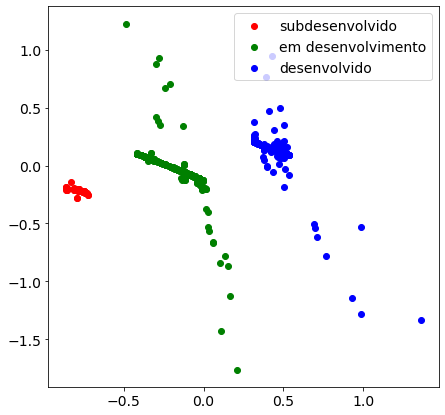

No handles with labels found to put in legend.


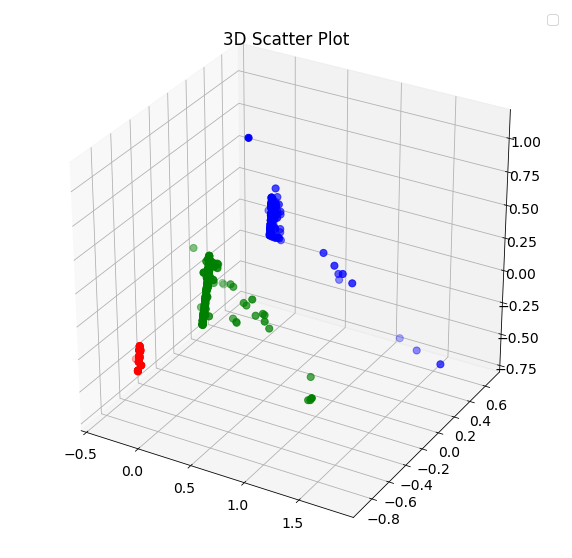

In [ ]:
import subprocess

for i in range(len(analise)):
  bashCommand = 'mkdir /content/drive/Shareddrives/MQAA/dados/mds/analise_'+ str(i+1)

  process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
  output, error = process.communicate()
  dataAnalysis = analise[i]
  scaledData = scaler_data(dataAnalysis)
  distanceMatrix = matrixDistanceCalc(scaledData, dataAnalysis)
  distanceMatrix.to_csv('/content/drive/Shareddrives/MQAA/dados/mds/analise_'+ str(i+1)+'/distance_matrix.csv')
  elbowPlot(scaledData, distanceMatrix, i)
  mds = mds2d(scaledData, dataAnalysis, i)
  MDSAnalysis(mds, distanceMatrix, '2D', i)
  mds = mds3d(scaledData, dataAnalysis, i)
  MDSAnalysis(mds, distanceMatrix, '3D', i)